In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
MODEL_OUT_NAME = 'baseline-model-02.pt'

###  imports

In [3]:
import os

import torch
import torch.nn.functional as F

import numpy as np
import pandas as pd
import rasterio

import glob

%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import json

In [4]:
from IPython.display import clear_output


In [5]:
from pathlib import Path
_src_path = Path(os.getcwd()).parent / 'src' 

In [6]:
import sys 
# print(sorted(sys.path))
if _src_path.as_posix() not in sys.path: 
    sys.path.append(_src_path.as_posix())
#     print(sorted(sys.path))

In [7]:
from agbmfc.loading import read_image_tensor, \
                            get_chip_tensor, \
                            get_chip_files, \
                            chip_tensor_to_pixel_tensor, \
                            get_pixel_target_tensor, \
                            generate_processed_files

from agbmfc.dataset import PSSBatchDataset
from agbmfc.model import train_one_epoch, evaluate

### Lock random state

In [8]:
np.random.seed(42)

### Constants 

In [9]:
DATA_ROOT = r'/data/driven_data_bio_massters'
DATA_TARGET_ROOT = os.path.join(DATA_ROOT, 'train_agbm')
DATA_FEATURES_ROOT = os.path.join(DATA_ROOT, 'train_features')


### DataSet

#### update features_meta accordn our train/dev split

In [10]:
with open(r'../data/md/chips_from_partition.json') as fd: 
    chips_from_split = json.load(fd)

In [11]:
len(chips_from_split['dev']), len(chips_from_split['train'])

(1738, 6951)

In [12]:
features_meta = pd.read_csv(os.path.join(DATA_ROOT, 'features_metadata.csv'))

In [13]:
features_meta['split'] = np.where(features_meta.chip_id.isin(chips_from_split['dev']), 'dev', features_meta.split)

In [14]:
features_meta.sample(1)


,filename,chip_id,satellite,split,month,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm
251199,fed6bb57_S2_07.tif,fed6bb57,S2,train,April,1443550,533223059,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,fed6bb57_agbm.tif


In [15]:
features_meta.groupby('split', sort=False).agg({'chip_id': pd.Series.nunique})

,chip_id
split,
train,6951
dev,1738
test,2773


In [16]:
chip = 'fed6bb57'
# 
# features_meta[features_meta.chip_id == chip]


In [17]:
# train_image_mask = os.path.join(DATA_ROOT, 'train_features', f'{chip}_*.tif')
# features_meta_chip_data = 
# train_images_s1 = features_meta[(features_meta.chip_id == chip) & (features_meta.s)]

### Check how many files missed for cheaps

array([<AxesSubplot:title={'center':'S1'}>,
       <AxesSubplot:title={'center':'S2'}>], dtype=object)

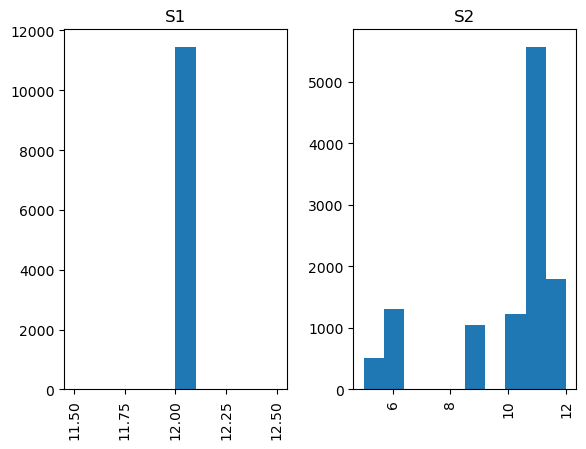

In [18]:
img_counts = features_meta.groupby(['chip_id', 'satellite'], as_index=False).filename.count()
img_counts.hist(by='satellite')

In [19]:
img_counts.groupby('satellite').chip_id.count()

satellite
S1    11462
S2    11462
Name: chip_id, dtype: int64

### agbm example

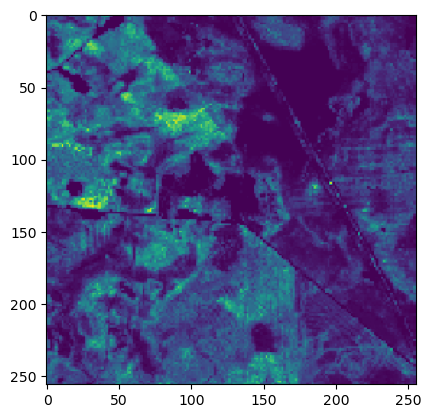

In [20]:


agbm_path = os.path.join(DATA_TARGET_ROOT, 'fed6bb57_agbm.tif' )

# img = io.imread(agbm_path) / 1e4  # why we devide here 1e4, Alex?
img = io.imread(agbm_path) 
plt.figure()  
plt.imshow(img)
plt.show()


In [21]:
img.flatten().size

65536

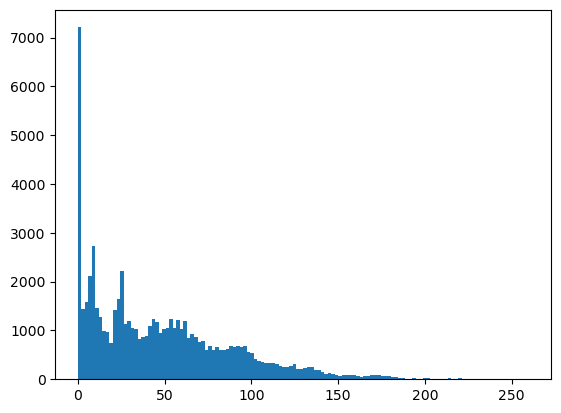

In [22]:
plt.hist(img.flatten()
         , bins=128,
        );
# plt.hist(img.flatten()
#          , bins=128, 
#          log=True
#         );

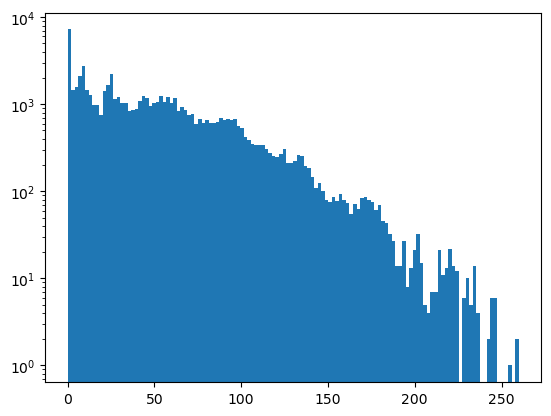

In [23]:
plt.hist(img.flatten()
         , bins=128, log=True
        );

### Sampler 

In [24]:
# let first build df from one sample 
#    let imagine that it contain only one image 



In [25]:
DATA_FEATURES_ROOT

'/data/driven_data_bio_massters/train_features'

In [26]:

glob.glob(DATA_FEATURES_ROOT + '/*fed6bb57*')

['/data/driven_data_bio_massters/train_features/fed6bb57_S1_07.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S2_08.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_02.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_09.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_05.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S2_07.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_06.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S2_05.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S2_06.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_00.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S2_09.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_10.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S2_10.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S2_01.tif',
 '/data/driven_data_bio_massters/t

In [27]:
path = r'/data/driven_data_bio_massters/train_features/fed6bb57_S1_08.tif'

#### image

In [28]:
image_tensor = read_image_tensor(path, precision=16)
    

In [29]:
image_tensor.shape

torch.Size([4, 256, 256])

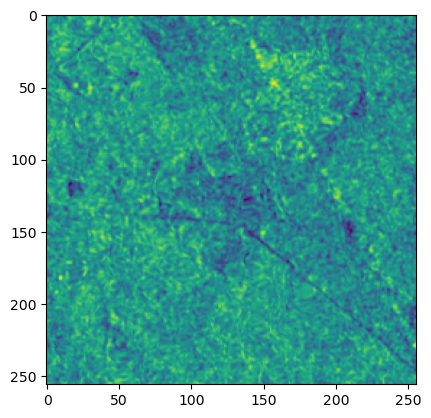

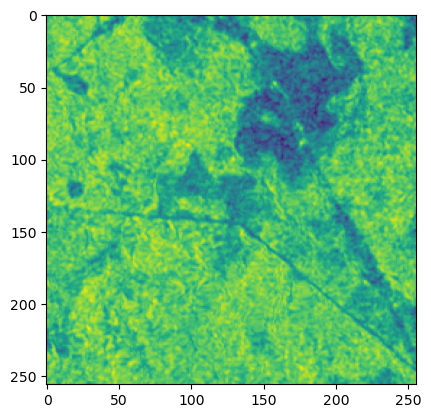

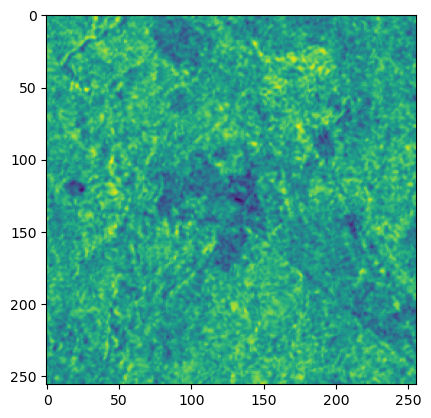

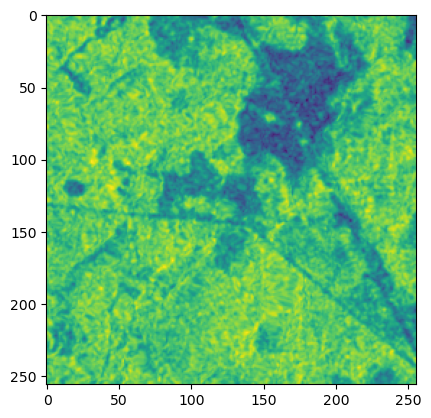

In [30]:
for layer in image_tensor: 
    plt.figure()  
    plt.imshow(layer)
    plt.show()


#### chip tensor

In [31]:
chip_files_s1 = get_chip_files(chip, s2=False)

In [32]:
chip_tensor = get_chip_tensor(chip_files_s1)

In [33]:
chip_tensor.shape

torch.Size([12, 4, 256, 256])

In [34]:
pixel_tensor = chip_tensor_to_pixel_tensor(chip_tensor)
pixel_target_tensor = get_pixel_target_tensor(chip)

In [35]:
pixel_tensor.shape, pixel_target_tensor.shape

(torch.Size([65536, 12, 4]), torch.Size([65536, 1]))

In [36]:
%%time 
_ = get_chip_files(chip, s2=False)

CPU times: user 151 ms, sys: 71.5 ms, total: 222 ms
Wall time: 222 ms


In [37]:
%%time
tmp = get_chip_tensor(chip_files_s1)

CPU times: user 161 ms, sys: 10.7 ms, total: 172 ms
Wall time: 30.2 ms


In [38]:
%%time
tmp = chip_tensor_to_pixel_tensor(tmp)

CPU times: user 122 µs, sys: 14 µs, total: 136 µs
Wall time: 110 µs


In [39]:
chip_batch_size = 100
# pixel_samples = 10_000 
samples_from_chip = 1_000

train_chips = list(features_meta[features_meta.split == 'train'].chip_id.unique())

batch_chips = train_chips[:chip_batch_size]

In [40]:
from tqdm.auto import tqdm

In [41]:
import time

In [42]:
# 11k чипов
# т.е. на создание одного батчей по всему датасету у меня уйдет 20 * 11_000/100 ~ 36 минут О_О

#### Outliers in the target

In [43]:
batch_target = torch.load(r'../data/processed/train/batch-000000-target.pt')
batch_features = torch.load(r'../data/processed//train/batch-000000-features.pt')

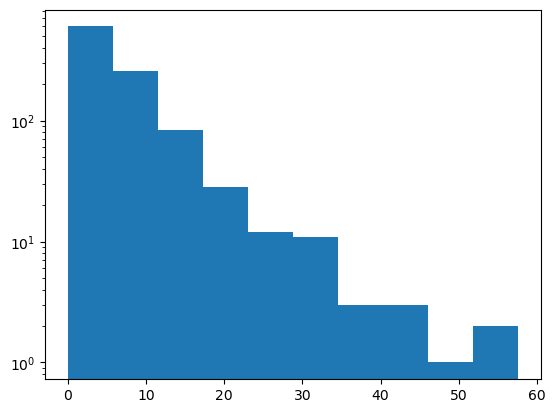

In [44]:
plt.hist(batch_target[:,0], log=True);

In [45]:
outlier_file = batch_chips[0]
max_val = 0
for chip in batch_chips: 
#     target_pixel_tensor = get_pixel_target_tensor(chip)
    
    file = os.path.join(DATA_TARGET_ROOT, f'{chip}_agbm.tif')
    image = read_image_tensor(file)
    if image.max().item() > max_val: 
        max_val = image.max().item()
        outlier_file = file
    

In [46]:
outlier_file
# '/data/driven_data_bio_massters/train_agbm/011909e9_agbm.tif'

'/data/driven_data_bio_massters/train_agbm/011909e9_agbm.tif'

In [47]:
image = read_image_tensor(outlier_file)

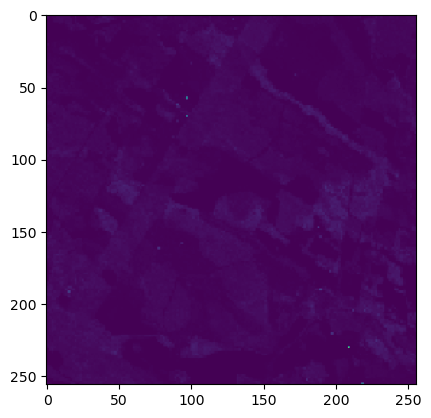

In [48]:
for layer in image: 
    plt.figure()  
    plt.imshow(layer)
    plt.show()
    
# Что за ?

In [49]:
target_pixel_tensor = get_pixel_target_tensor(chip)

In [50]:
image.max().item()

4889.68017578125

In [51]:
target_pixel_tensor.max()

tensor(599.0400)

In [52]:
batch_target[:,0].max()

tensor(57.6200)

In [53]:
batch_target.shape

torch.Size([1000, 1])

In [54]:
pixel_tensor.shape

torch.Size([65536, 12, 4])

In [55]:
chip_files_s1

['/data/driven_data_bio_massters/train_features/fed6bb57_S1_00.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_01.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_02.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_03.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_04.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_05.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_06.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_07.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_08.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_09.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_10.tif',
 '/data/driven_data_bio_massters/train_features/fed6bb57_S1_11.tif']

### Dataset

In [56]:
_OBJ_COUNT = 2

In [57]:
 sorted(glob.glob(rf'../data/processed/train/batch-*-features.pt'))

['../data/processed/train/batch-000000-features.pt',
 '../data/processed/train/batch-000001-features.pt',
 '../data/processed/train/batch-000002-features.pt',
 '../data/processed/train/batch-000003-features.pt',
 '../data/processed/train/batch-000004-features.pt',
 '../data/processed/train/batch-000005-features.pt',
 '../data/processed/train/batch-000006-features.pt',
 '../data/processed/train/batch-000007-features.pt',
 '../data/processed/train/batch-000008-features.pt',
 '../data/processed/train/batch-000009-features.pt',
 '../data/processed/train/batch-000010-features.pt',
 '../data/processed/train/batch-000011-features.pt',
 '../data/processed/train/batch-000012-features.pt',
 '../data/processed/train/batch-000013-features.pt',
 '../data/processed/train/batch-000014-features.pt',
 '../data/processed/train/batch-000015-features.pt',
 '../data/processed/train/batch-000016-features.pt',
 '../data/processed/train/batch-000017-features.pt',
 '../data/processed/train/batch-000018-feature

In [58]:
torch.load('../data/processed/train/batch-000051-features.pt').shape

torch.Size([1000, 12, 4])

In [59]:
# batch_dataset = PSSBatchDataset(data_dir=rf'../data/processed/', _limit=1024)
train_dataset = PSSBatchDataset(data_dir=r'../data/processed/train/',)
val_dataset = PSSBatchDataset(data_dir=r'../data/processed/val/',)

In [60]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1000, 12, 4]), torch.Size([1000, 1]))

In [61]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4)

In [62]:
len(train_dataset)

6951

In [63]:
for _x, _y in train_dataloader:
    pass

In [64]:
_x.shape

torch.Size([3, 1000, 12, 4])

In [65]:
_x[0].shape

torch.Size([1000, 12, 4])

In [66]:
_y.shape

torch.Size([3, 1000, 1])

In [67]:
len(train_dataset), len(train_dataloader)

(6951, 1738)

### Model

In [68]:
# okq - whats dim? - dim of image (256*256) => dim = 256

# okq - rel_date - what is it? why [bs, seq_len]
# okq - date - what is it? why [bs, seq_len]
# answer - just index of month (calendar and index of observation)

# q - why nhead=8 for encoder? What's stragedy to define it properly

# okq - what is ddict['bands'] s1 data 

# q - why we name it logits? logits = self.head(out).squeeze(2) 
# q nn.Module.log_dict
class PixelBLRegessor(torch.nn.Module):
    def __init__(self, dim=256, seq_len=12, channels=4):
        super().__init__()

        self.dim = dim
        self.seq_len = seq_len
        self.channels = channels
    
        self.s1_band = torch.nn.Linear(channels, self.dim) # ds, looks like it should be channels (was 10)
        
        # rel_date/date -- это инты из файла или путей к картинкам [bs, seq_len]
#         self.rel_date = nn.Embedding(20, self.dim)
#         self.date = nn.Embedding(20, self.dim)

        # ds: looks like no reason dim == d_model          

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=self.dim, nhead=8, batch_first=True)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.regressor = torch.nn.Linear(self.dim, 1)
    
    def forward(self, ddict):
        
        features = self.s1_band(ddict["bands"])
        out = self.encoder(features)
        logits = self.regressor(out).squeeze(2)

        return logits
        
    def loss_fn(self, x, target, prefix: str = "train"):
        # тут я несколько намудрил, но идея простая -- взять предикты для нулевого токена и посчитать лосс
        # q - почему мы считаем, что взять предиктры для нулевого токена это ок? может я не совсем понимаю, что есть нулевой токен?
        bs = len(target)
        x_ = x[:, 0]
        y_ = target
        loss = torch.sqrt(F.mse_loss(x_, y_, reduction="none") + 1e-8).mean()
#         rmse = torch.sqrt(F.mse_loss(x_, y_, reduction="none")).mean()
#         metric_from_name = {
#                 f"{prefix}_loss({str(self.loss_fn)})": loss,
#                 f"{prefix}_rmse": rmse,
#             }
        
    #         self.log_dict(metric_from_name, batch_size=bs) # lightning feature
        return loss            

In [69]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

In [70]:
model = PixelBLRegessor()
model = model.to(device)
model.eval();

In [71]:
x = train_dataset[0][0][:1024]
x = x.to(device)
y = train_dataset[0][1][:1024]
y = y.to(device)

In [72]:
x.element_size() * x.nelement()

192000

In [73]:
x.shape

torch.Size([1000, 12, 4])

In [74]:
%%time
# this to slow
# _pred = model.forward({'bands': x})
_pred = model({'bands': x})

CPU times: user 1.8 s, sys: 599 ms, total: 2.4 s
Wall time: 314 ms


In [75]:
import gc

In [76]:
gc.collect()

41442

In [77]:
# origin: do not edit 
import torch.nn as nn
class PerPixelPlainRegression(nn.Module):
    def __init__(self, dim=256):
        super().__init__()
        self.s2_stem = nn.Linear(10, dim)
        self.rel_date = nn.Embedding(20, dim)
        self.date = nn.Embedding(20, dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=8, batch_first=True)
        self.inner = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.head = nn.Linear(dim, 1)
        self.dim = dim

    def forward(self, ddict):
        # ddict -- это словарь с тензорами и всяким добром
        # bands.shape = [bs, seq_len, 10 или сколько там]
        features = self.s2_stem(ddict["bands"])
        # rel_date/date -- это инты из файла или путей к картинкам [bs, seq_len]
        embs = self.rel_date(ddict["rel_date"])
        embs = embs + self.date(ddict["date"])
        features = features + embs

        cloud_mask = (ddict["clouds"].squeeze(2) > 0.5)
        # вот тут применяется трансформер-энкодер, pad_mask -- True на паддингах -- он не должен на них смотреть 
        # (в смысле внимание будет давать нулевые коэффициенты для таких токенов, можно так же запретить смотреть на облачные точки)
        out = self.inner(features, src_key_padding_mask=ddict["pad_mask"])
        logits = self.head(out).squeeze(2)

        return {"logits": logits, "pad_mask": ddict["pad_mask"]} # mb add cloud mask

    def loss_fn(self, target, prediction, pad_mask, prefix: str = "train"):
        # тут я несколько намудрил, но идея простая -- взять предикты для нулевого токена и посчитать лосс
        bs = target.shape[0]
        x_ = prediction[:, 0]
        y_ = target
        loss = torch.sqrt(F.mse_loss(x_, y_, reduction="none") + 1e-8).mean()
        rmse = torch.sqrt(F.mse_loss(x_, y_, reduction="none")).mean()
        self.log_dict({
                f"{prefix}_loss({str(self.loss_fn_)})": loss,
                f"{prefix}_rmse": rmse,
            },
            batch_size=bs)
        return loss


In [78]:
# origin: do not edit
def load_cube(paths: list, max_len: int = 12):
    cube = np.stack([io.imread(p) for p in paths])
    seq_len = cube.shape[0]
    cube = np.pad(cube, ((0, max_len - seq_len), (0, 0), (0, 0), (0, 0)), mode="constant", constant_values=0)
    
    pad_mask = np.ones(max_len, dtype=np.bool_)
    pad_mask[:seq_len] = False

    bands = cube[..., :-1].astype(np.float32) / 1e4
    clouds = cube[..., -1:].astype(np.float32) / 1e2
    return bands, clouds, pad_mask

_bands, _clouds, _pad_mask = load_cube(chip_files_s1)

### train stuff

In [79]:

import matplotlib.pyplot as plt

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()



def predict(model, _dataloder, epoch=0, device="cuda:0"):
    model.eval()    
    raise NotImplementedError
    

def train(model, train_dataloader, val_dataloader, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)

    train_loss_log, val_loss_log  = [], []

    best_epoch = best_tra_loss = 0
    
    for epoch in tqdm(range(n_epochs), ):
        
        epoch_loss = train_one_epoch(model, train_dataloader, optimizer, epoch, device)
        scheduler.step()
        train_loss_log.append(epoch_loss)

        val_loss = evaluate(model, val_dataloader, device)
        val_loss_log.append(val_loss)
        
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        
        print("Train loss:", epoch_loss)
        

In [80]:
PixelBLRegessor()

PixelBLRegessor(
  (s1_band): Linear(in_features=4, out_features=256, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256

In [81]:
import torch.optim as optim

In [82]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = PixelBLRegessor()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9) 

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
n_epochs = 32 #  8 # NUMBER OF EPOCHS
# n_epochs = 48 #  8 # NUMBER OF EPOCHS
device

device(type='cuda', index=0)

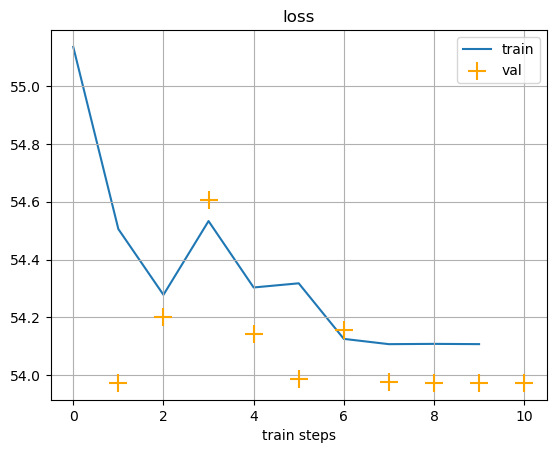

Train loss: 54.10755
CPU times: user 32min 25s, sys: 6min 12s, total: 38min 37s
Wall time: 29min 1s


In [85]:
%%time
# model = model_baseline
# train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs, scheduler)
n_epochs = 10
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs, scheduler)

In [88]:
model.to(device)

evaluate(model, val_dataloader, device)

evaluation:   0%|          | 0/435 [00:00<?, ?it/s]

53.974094

In [87]:
if os.path.exists(MODEL_OUT_NAME): 
    raise ValueError('Model file already exists!')

torch.save(model, MODEL_OUT_NAME)